In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from poker_embeddings.poker_utils.constants import HANDS_DICT


In [131]:
ev_data = pd.read_csv("../data/processed/hand_ev_processed.csv")

In [132]:
ev_data['players_cat'] = pd.Categorical(ev_data['players'], ordered=True)
ev_data['position'] = pd.Categorical(ev_data['position'],
               categories=["SB","BB","pos3",'pos4','pos5','pos6','pos7','pos8','pos9','D'],
               ordered=True)

In [133]:
heatmap_data = ev_data.groupby(['players_cat','position'], observed=True)['EV_deviation'].mean().reset_index()\
    .pivot_table(values="EV_deviation",columns="position",index='players_cat', observed=True)

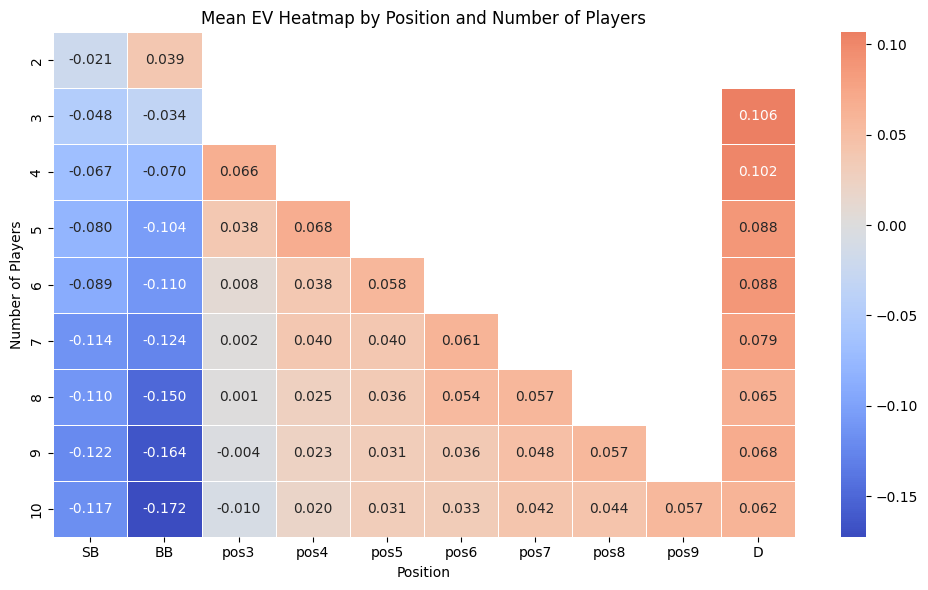

In [134]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".3f", linewidths=0.5, center=0)

plt.title("Mean EV Heatmap by Position and Number of Players")
plt.xlabel("Position")
plt.ylabel("Number of Players")
plt.tight_layout()
plt.show()

<Axes: xlabel='EV_deviation', ylabel='Count'>

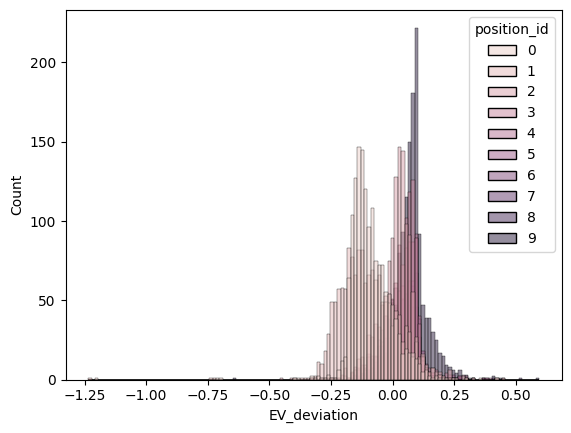

In [135]:
sns.histplot(data=ev_data, x='EV_deviation', hue="position_id")

<Axes: xlabel='EV_deviation', ylabel='Count'>

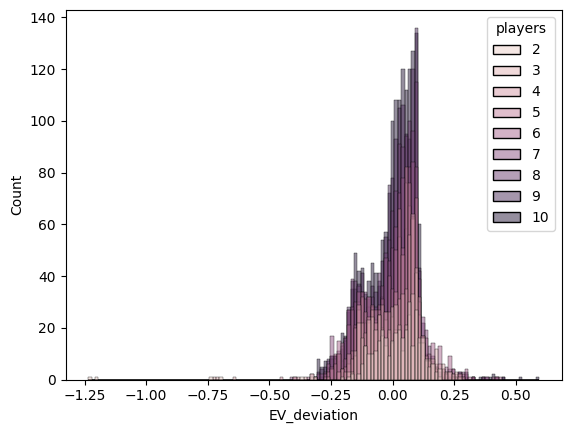

In [136]:
sns.histplot(data=ev_data, x='EV_deviation', hue="players")

In [137]:
def plot_hand_ev(hand, aggregate=False):
    ev_data[ev_data.hand==hand]
    plot_data = ev_data[ev_data.hand==hand].copy()

    plt.figure(figsize=(6, 4))
    if aggregate:
        plot_data = plot_data.groupby('players',observed=False)['EV_deviation'].mean().reset_index()
        sns.lineplot(plot_data, x='players',y='EV_deviation')
    else:
        for position in ev_data.position.unique():
            sns.lineplot(plot_data[plot_data.position == position],
                     x='players',
                     y='EV_deviation',
                     label=position)

    plt.title(f"EV Deviation for {hand}")
    plt.xlabel("Number of Players")
    plt.ylabel("EV Deviation")
    plt.tight_layout()
    plt.show()

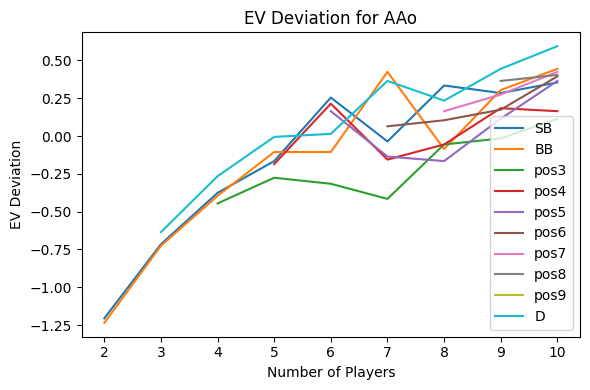

In [138]:
plot_hand_ev("AAo")

In [139]:
EV_profiles = ev_data[['hand','pos_play','EV']].pivot(index='hand', columns="pos_play", values="EV")

In [140]:
# EV_profiles = EV_profiles.loc[~EV_profiles.index.isin(["AAo", "KKo"])]

In [141]:
hands = EV_profiles.index

In [142]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [143]:
EV_norm = normalize(EV_profiles.to_numpy(), norm='l2', axis=1)
ev_similarity = pd.DataFrame(cosine_similarity(EV_norm), index=hands, columns=hands)

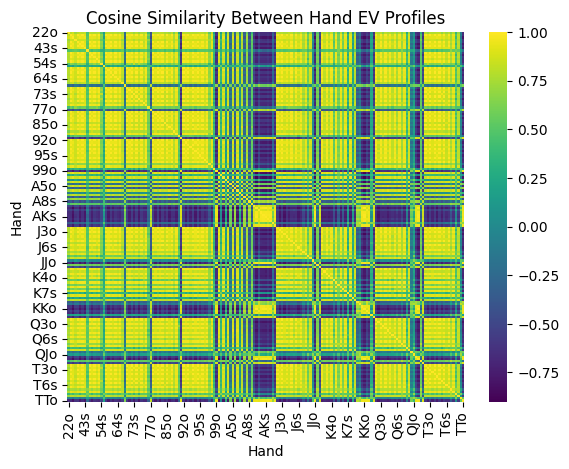

In [144]:
sns.heatmap(ev_similarity, cmap="viridis")
plt.title("Cosine Similarity Between Hand EV Profiles")
plt.xlabel("Hand")
plt.ylabel("Hand")
plt.show()

In [145]:
from sklearn.cluster import AgglomerativeClustering

[10  6 22  5  8 57  6 33 10 12]


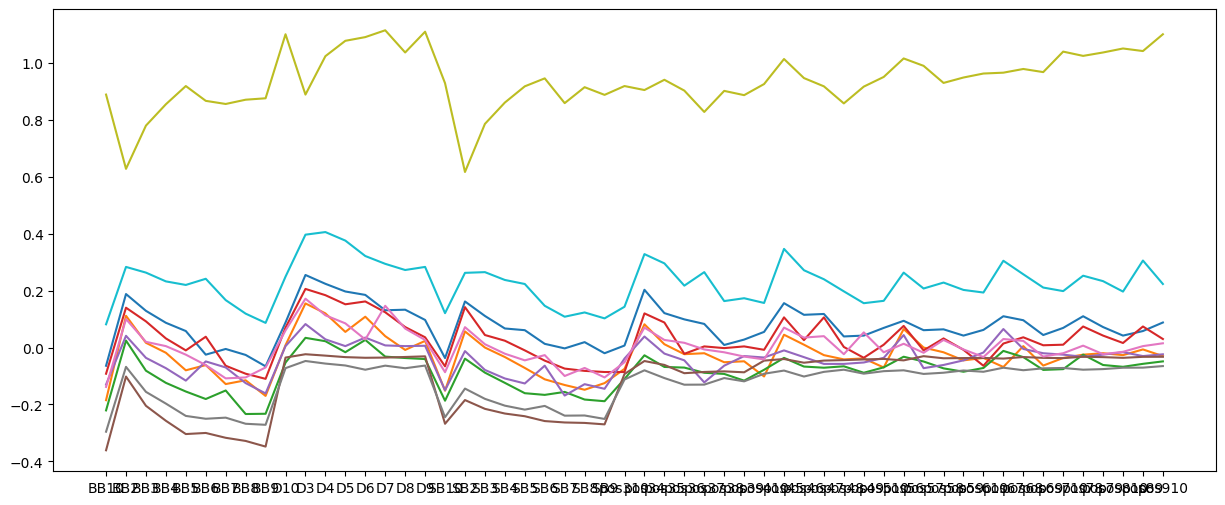

In [163]:
clustering = AgglomerativeClustering(
    linkage='ward',
    n_clusters=10
)
labels = clustering.fit_predict(1 - ev_similarity)
print(np.unique(labels, return_counts=True)[1])
plt.figure(figsize=(15, 6))
for cluster_id in np.unique(labels):
    mean_curve = EV_profiles[labels == cluster_id].mean(axis=0)
    plt.plot(mean_curve, label=f"Cluster {cluster_id}")

array([112,  11,  22,  14,  10])